# Clustering Case Study: Customer Segmentation with K-Means 
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering ,DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
print(df_offers.shape)
df_offers.head()

(32, 7)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [4]:
df_offers.varietal.unique()

array(['Malbec', 'Pinot Noir', 'Espumante', 'Champagne',
       'Cabernet Sauvignon', 'Prosecco', 'Chardonnay', 'Merlot',
       'Pinot Grigio'], dtype=object)

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
df_transactions = pd.read_excel("WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
print(df_transactions.shape)
df_transactions.head()

(324, 3)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [6]:
df_offers.isna().sum()

offer_id     0
campaign     0
varietal     0
min_qty      0
discount     0
origin       0
past_peak    0
dtype: int64

In [7]:
df_transactions.isna().sum()

customer_name    0
offer_id         0
n                0
dtype: int64

In [8]:
#your turn
df = df_transactions.merge(df_offers,left_on= 'offer_id' , right_on= 'offer_id')
print(df.shape)
df.head()

(324, 9)


,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False
2,Martin,2,1,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,January,Pinot Noir,72,17,France,False


In [9]:
by_offer_customer = df.pivot_table(index= 'customer_name', columns='offer_id', values= 'n').fillna(0)
print(by_offer_customer.shape)
by_offer_customer.head()

(100, 32)


offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [10]:
#Create a numpy matrix with only columns representing the offers
X = by_offer_customer.to_numpy()
X

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [11]:
#Create a list of number of clusters
ks = list(range(2,11))

#Create an empty dictionary
assignments = {}

#Create an empty list for sum of squared
ss = []

#Fill the dictionary with assigned cluster(s) by each model with K clusters
for k in ks:
    model = KMeans(n_clusters=k)
    assigned_clusters = model.fit_predict(X)
    centroids = model.cluster_centers_
    #Fill ss with the sum-of-squares differences between all data and cluster centers(measure similarity)
    ss.append( np.sum((X - centroids[assigned_clusters])**2) )
    assignments[str(k)] = assigned_clusters
     


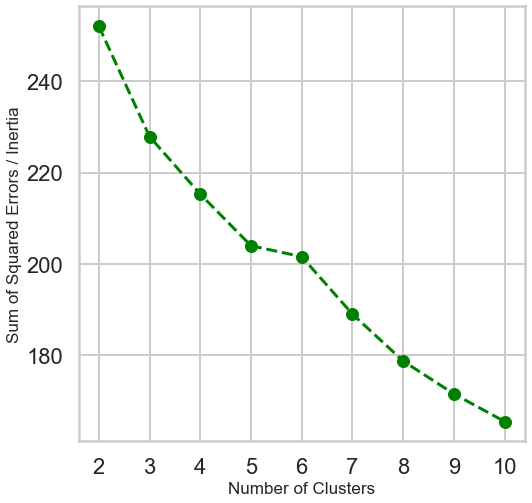

In [12]:
plt.figure(figsize=(8,8))
plt.plot(ks, ss,  color='green', marker='o', linestyle='dashed')
plt.xlabel('Number of Clusters', fontsize=17)
plt.ylabel('Sum of Squared Errors / Inertia', fontsize=17)
plt.xticks(ks)
plt.show()

**When number of clusters increases from 2 to 3, the sum of squared errors of clusters(inertia) significantly drops. Increasing number of clusters reduces the ss of errors or ineria. So, having 2 or 3 clusters results in higher inertia and better clustering.**

In [13]:
#Check how the customers are to these three clusters 
best_k= 3
assignment_best_k = assignments[str(best_k)]
print(assignment_best_k)

[1 0 2 1 1 0 2 1 0 1 0 2 1 0 0 2 0 2 1 0 1 1 0 0 2 0 0 0 0 2 1 1 0 0 1 1 0
 1 0 1 2 2 1 0 1 0 1 1 0 0 0 0 0 2 1 1 2 1 1 0 0 1 0 1 1 2 2 0 0 0 0 0 0 1
 0 1 2 1 1 2 0 0 0 2 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0]


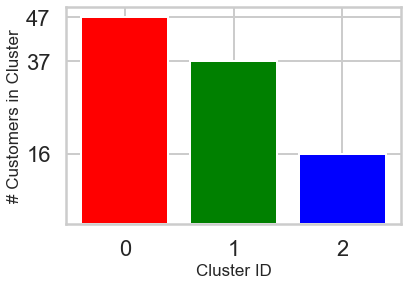

In [14]:
#Count the number of customers in each cluster
counts = np.bincount(assignment_best_k)

#plot the bars to show the number of customers in each cluster
plt.bar(range(best_k) , counts, align= 'center', width= 0.8, color=['red', 'green', 'blue'])
plt.yticks(counts)
plt.xlabel('Cluster ID', fontsize=17)
plt.ylabel('# Customers in Cluster', fontsize=17)
plt.show()


#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it helped me in the next exercise set.

**No substantial structure has beed found in data.**

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

###  A perspective into the density and separation of the formed clusters

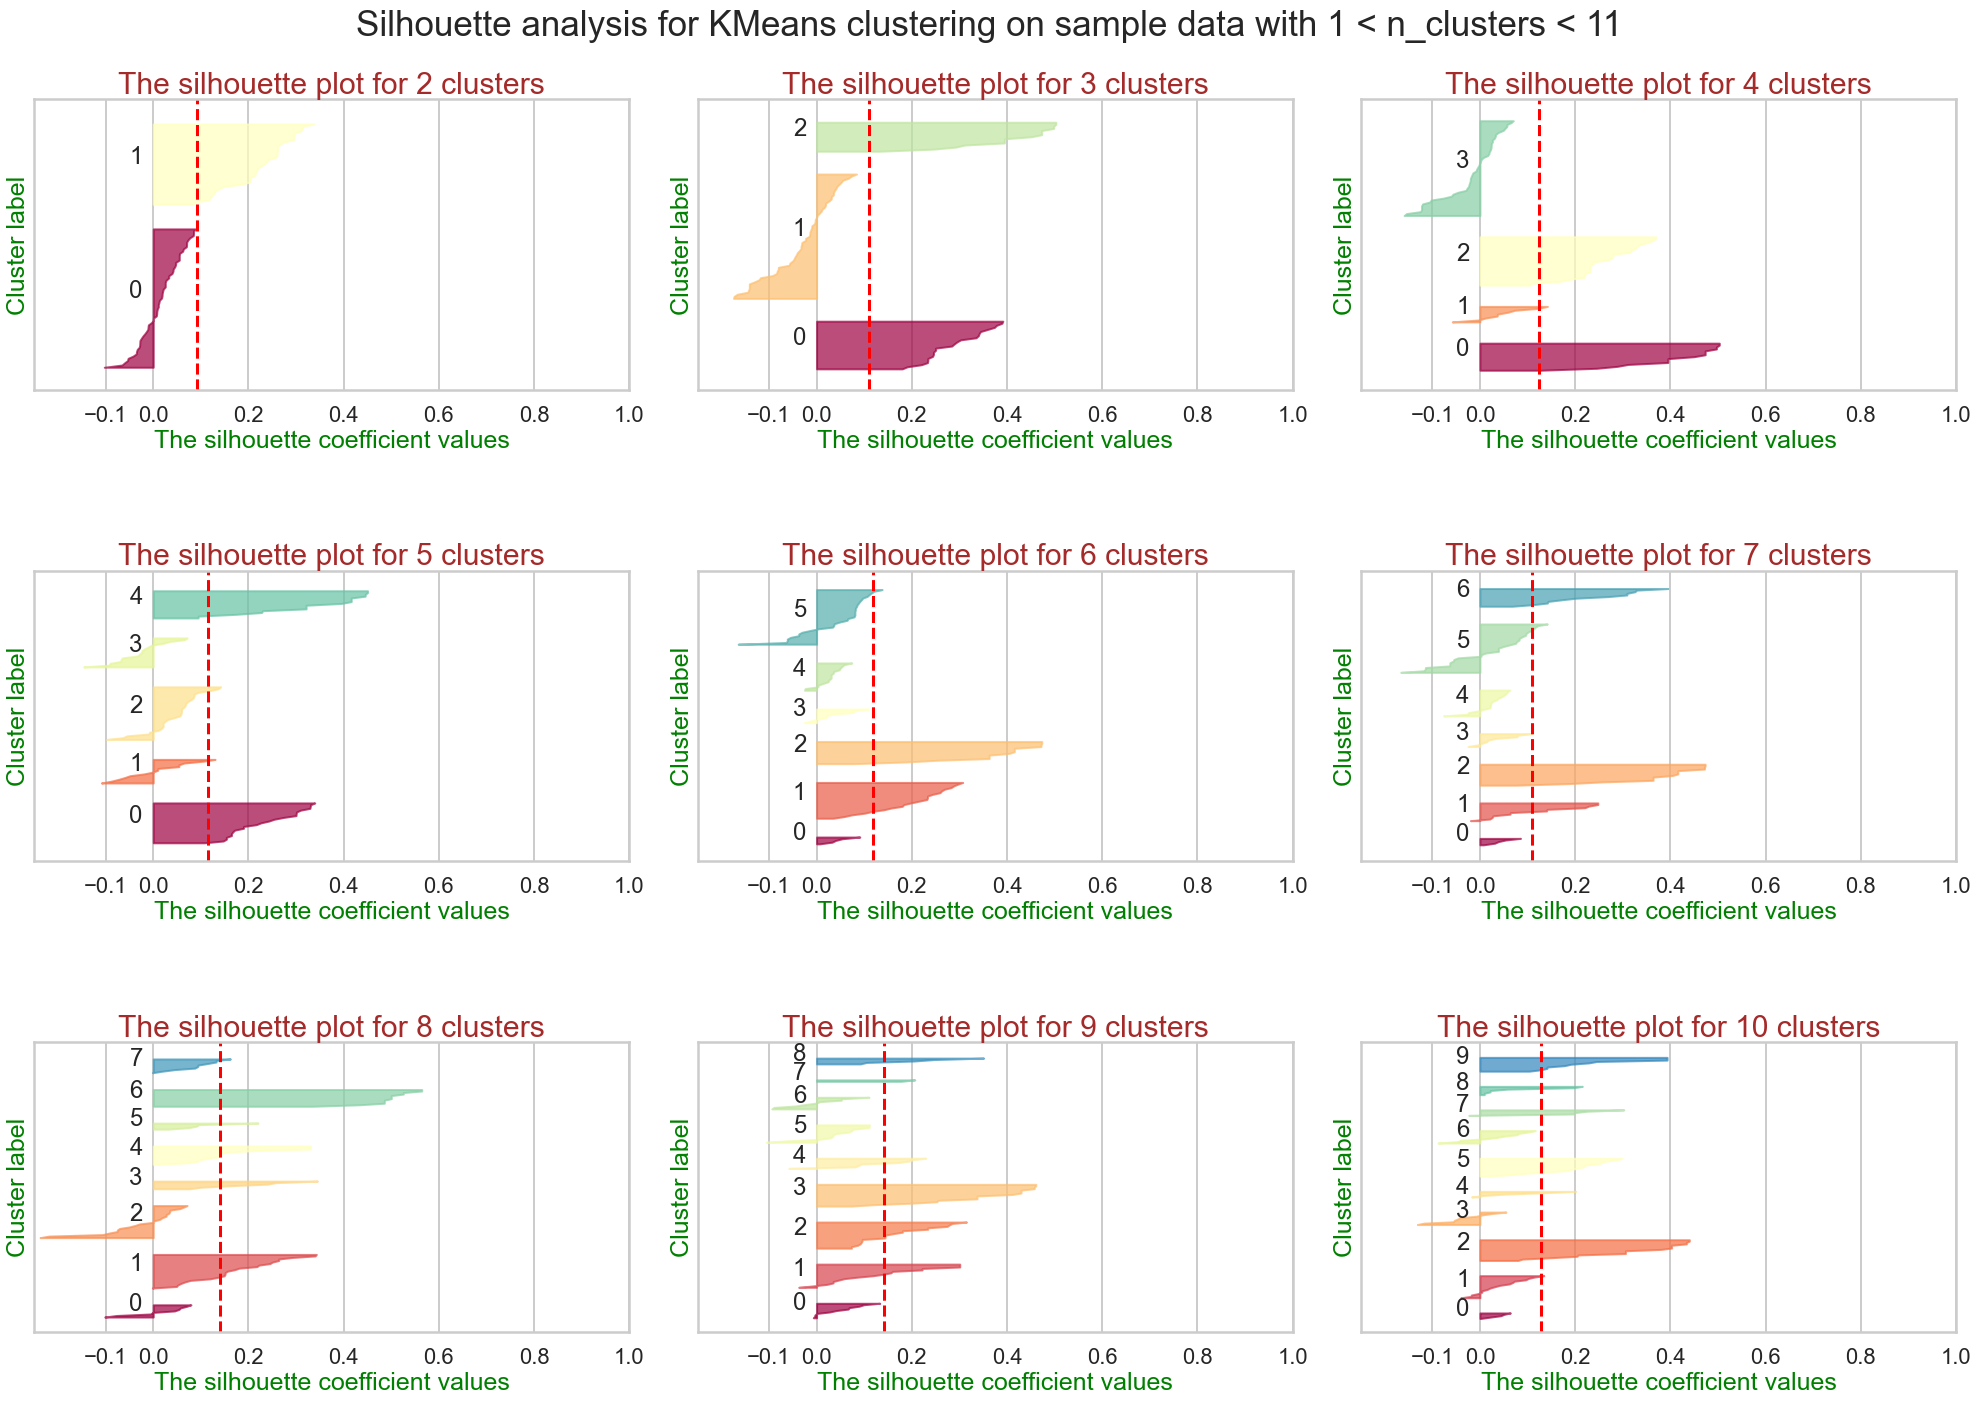

In [15]:
#SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


#Make an empty list to store the silhouette score
avg_silhouette_scores = []

ks = list(range(2,11))
fig, ax = plt.subplots(3,3)
fig.set_size_inches(28,20)

for idx, k in enumerate(ks):
    x_axes = idx // 3
    y_axes = idx % 3
    
    
    #The 1st subplot is the silhouette plot
    #The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax[x_axes][y_axes].set_xlim([-0.25,1])
    
    
    #The (n_clusters+1)*10 is for inserting blank space between silhouette
    #plots of individual clusters, to demarcate them clearly.
    ax[x_axes][y_axes].set_ylim([0, len(X) + (k+1)*10])
    
    
    #Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer= KMeans(n_clusters= k , random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    
    #The silhouette_score gives the average value for all the samples.
    #This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        #Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        #Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
        
        #Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i
        
        
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / k)
        ax[x_axes][y_axes].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        
        #Label the silhouette plots with their cluster numbers at the middle
        ax[x_axes][y_axes].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        
        #Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        
    #Setting title, xlabel and ylabel 
    ax[x_axes][y_axes].set_title('\n\nThe silhouette plot for {} clusters'.format(k), fontsize=30, c='brown')
    ax[x_axes][y_axes].set_xlabel("The silhouette coefficient values", fontsize=25, c= 'green')
    ax[x_axes][y_axes].set_ylabel("Cluster label", fontsize=25, c= 'green' )

    
    # Add the vertical line for average silhouette score of all the values
    ax[x_axes][y_axes].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[x_axes][y_axes].set_yticks([])  # Clear the yaxis labels / ticks
    ax[x_axes][y_axes].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle('Silhouette analysis for KMeans clustering on sample data with 1 < n_clusters < 11',
                 fontsize=35)

plt.tight_layout()
plt.show()


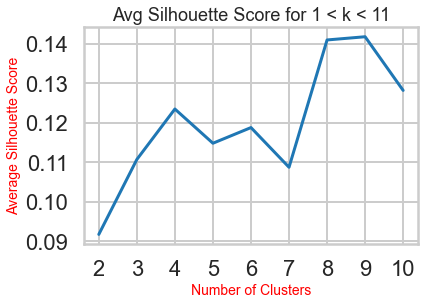

In [16]:
# Computing the avrage silhouette score for each K and plotting it 
# Call plot() with parameters KRange, avg_silhouette_scores
plt.plot(ks ,avg_silhouette_scores)
plt.title('Avg Silhouette Score for 1 < k < 11', fontsize=18)
plt.xticks(ks)
plt.yticks([0.09,0.10,0.11, 0.12,0.13, 0.14])
plt.xlabel('Number of Clusters', fontsize=14, c='red')
plt.ylabel('Average Silhouette Score', fontsize=14, c='red')
plt.show()


In [17]:
KMeans_sil_score = round(avg_silhouette_scores[1]*100, 2)
KMeans_n_cluster = 3

### Perspective into the density and separation of the formed clusters:

**Incresing number of clusters from 2 to 3, increased density and separation of clusters significantly. Increasing number of clusters from 3 to 4 increased density and separation slightly then reduce them.**

**Average Silhouette score has been less than 0.15 when number of clusters is between 2 and 10. It seems that there is not strong pattern in the data.**

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [18]:
#Fit a KMeans model with 3 clusters and assign data to the three cluster
kmeans = KMeans(n_clusters= 3)
cluster_ID = kmeans.fit_predict(X)
print(cluster_ID.shape)
print(cluster_ID)
print(type(cluster_ID))


(100,)
[2 1 0 2 1 1 0 2 1 2 1 0 2 1 1 0 1 0 2 1 2 2 1 1 0 1 1 1 1 1 2 2 1 1 2 2 1
 2 1 2 0 0 2 1 2 1 2 2 1 1 1 1 1 0 1 2 0 2 2 1 1 2 1 2 2 1 0 1 1 1 1 1 1 2
 1 2 0 2 2 0 1 1 1 0 2 2 2 1 1 2 1 2 1 2 1 1 2 1 1 1]
<class 'numpy.ndarray'>


In [19]:
#Create a PCA model with 2 components
pca = PCA(n_components= 2)
#Apply PCA model on X to transform data into 2D
pc1, pc2 = zip(*pca.fit_transform(X))


No handles with labels found to put in legend.


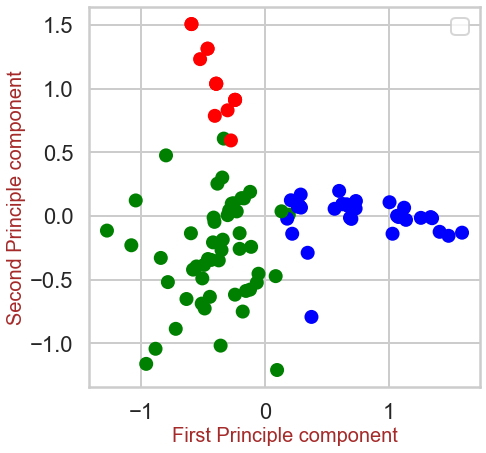

In [20]:
#Visualize transformed data in 2 dimensions, with the color indicating their cluster
plt.figure(figsize=(7,7))

cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])
plt.scatter(pc1, pc2 , c= cluster_ID.tolist(), cmap= cmap)    #convert numpy array to a list


plt.xlabel('First Principle component', fontsize= 20, c= 'brown')
plt.ylabel('Second Principle component', fontsize= 20, c= 'brown')
plt.legend(loc='best')
plt.show()

I have taken those columns of 0/1 indicator variables, and transformed them into a 2-D dataset. Now I can throw each point into a scatterplot. I colored each point based on it's cluster so it's easier to see them.

**Clusters don't have ovelapped. Blue and green clusters have higher variance than blue cluster.**
**I think two clusters is optimal, blue and red clusters can be merged.**

In [21]:
#Add cluster_ID for each customer
by_offer_customer['cluster_ID'] = cluster_ID.tolist()
by_offer_customer.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,cluster_ID
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


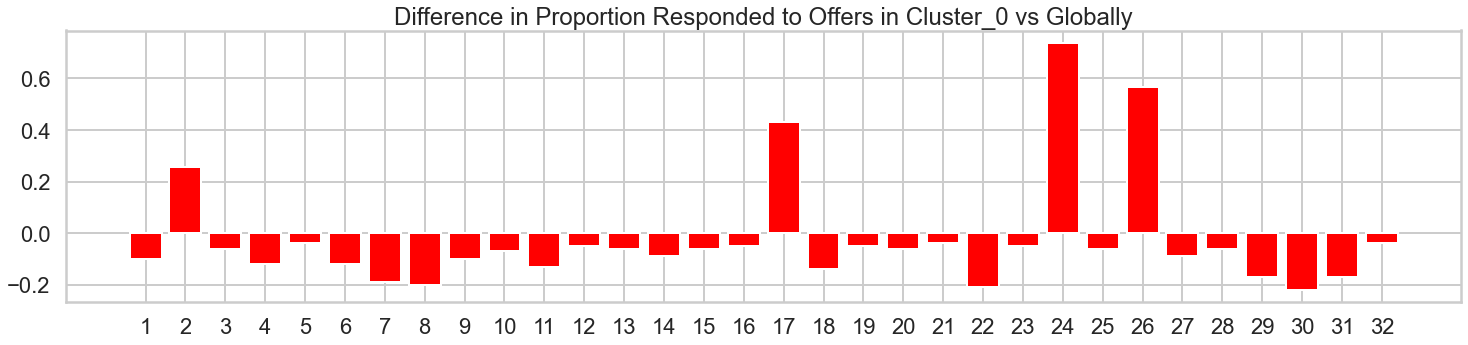

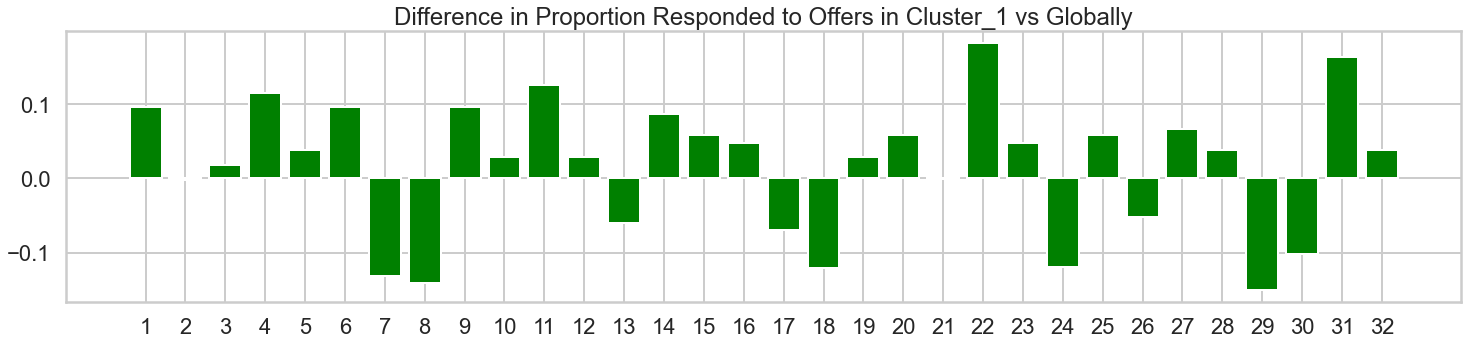

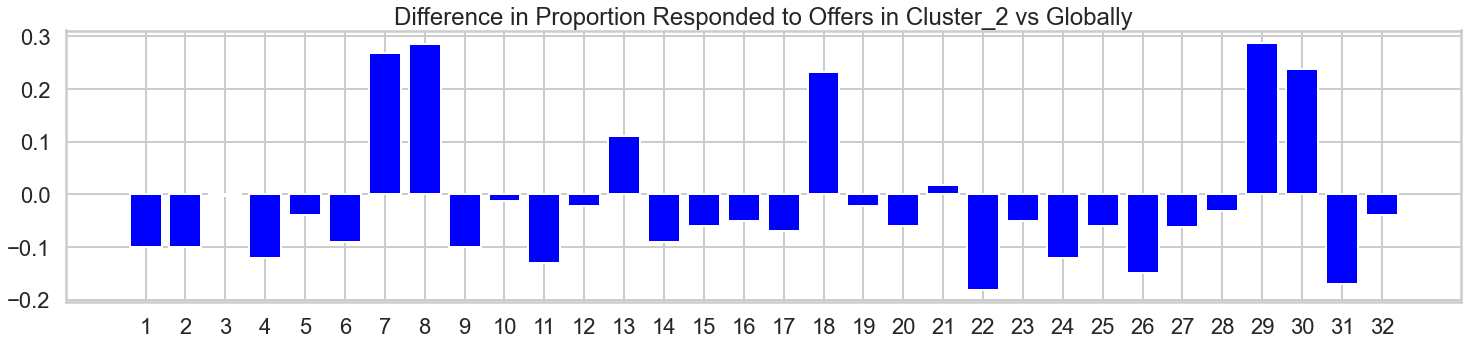

In [22]:
#Compute proportion of customers responded to each offer globally
n_of_customers = 100
offer_proportion = by_offer_customer.drop('cluster_ID',axis=1).sum(axis=0) / n_of_customers
offer_proportion


color = ['red', 'green', 'blue']
for i in range(3):
    #Filter customers in ith cluster
    small_by_offer_customer = by_offer_customer[cluster_ID == i].drop('cluster_ID',axis=1)
    
    #Compute proportion of customers responded to each offer in ith cluster
    offer_proportion_in_cluster = small_by_offer_customer.sum(axis=0) / small_by_offer_customer.shape[0]
    
    #Compute difference between how often each offer is responded in each cluster vs globally
    diff_offer_proportion = offer_proportion_in_cluster - offer_proportion 
   
    
    plt.figure(i, figsize=(25,5))
    plt.bar(list(np.arange(32)+1), height= diff_offer_proportion, color= color[i])
    plt.xticks(list(np.arange(32)+1))
    plt.title('Difference in Proportion Responded to Offers in Cluster_{} vs Globally'.format(i))
    plt.show()
    


**Customers in red and blue clusters responded similarly to offers with the ID of 7,8,17,18, 29,30 and 31 unlike customers in blue cluster. In general, customers in red and blue clusters had similar behavior, but customers in green cluster behaved differently.** 

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [23]:
pca = PCA()
pca.fit_transform(X)
features = pca.n_components_

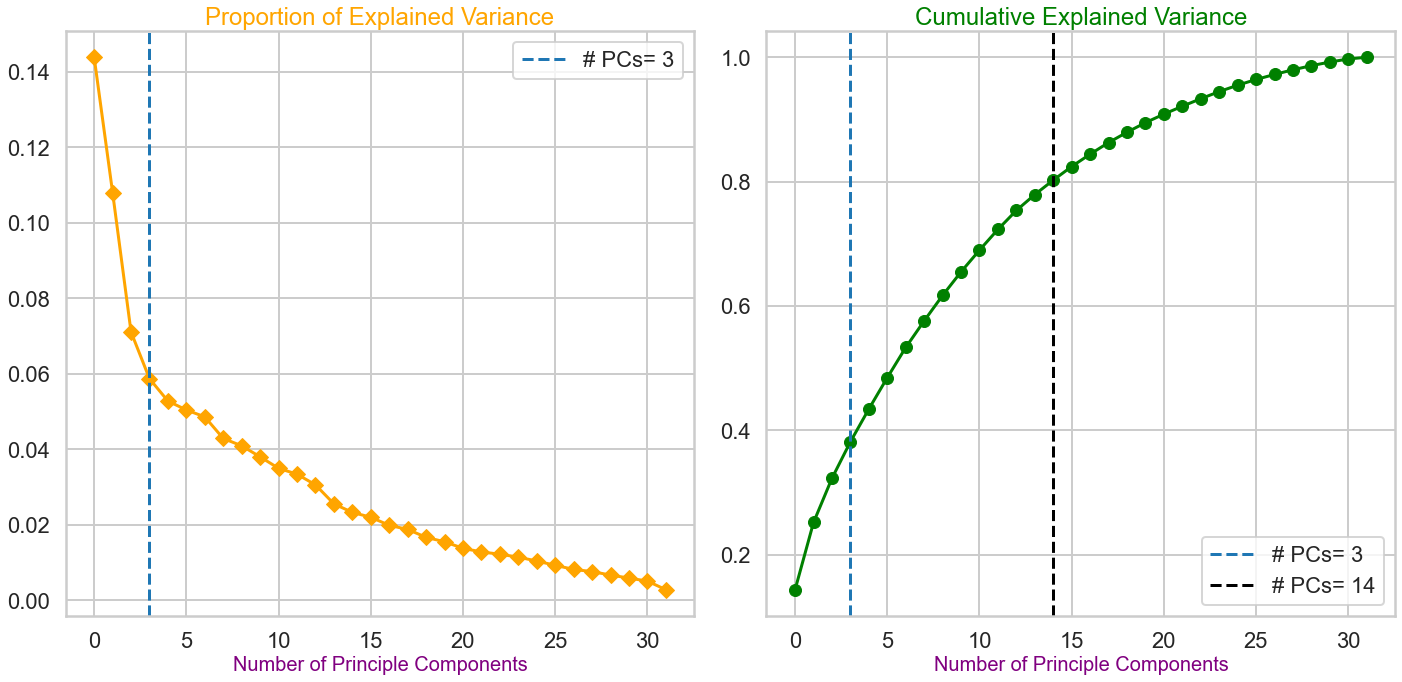

In [24]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

cumulative_var = np.cumsum(np.round(pca.explained_variance_ratio_,4))
ax[1].plot(range(len(pca.explained_variance_ratio_)), np.cumsum(np.round(pca.explained_variance_ratio_,4)), marker= 'o', c='green')
ax[1].set_xlabel('Number of Principle Components', fontsize=20, c='purple')
ax[1].axvline(x=3, ls='--', label= '# PCs= 3')
ax[1].axvline(x=14, ls='--', label= '# PCs= 14',c='black')
ax[1].set_title('Cumulative Explained Variance',c='green')
ax[1].legend()


ax[0].plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, marker='D',c='orange')
ax[0].set_xlabel('Number of Principle Components', fontsize=20, c='purple')
ax[0].set_title('Proportion of Explained Variance',c='orange')
ax[0].axvline(x=3, ls='--', label= '# PCs= 3')
ax[0].legend()


plt.tight_layout()
plt.show()


**Only 3 principle components can explain about 40% of variance in data set. But if I want the pca model explaines 80% of variance in data, 14 PCs should be selected. Each of forth, fifth and later principle components explains less than 6% of variance which is less than percentage of variance that each of first three PCs explains.**

## 4. Conclusions and next steps
### 4a. Conclusions
**The data set has a weak pattern. Customers can be clustered into two group.**

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [25]:
#Create a list for storing models score
sil_models = [KMeans_sil_score]
n_clusters_models = [KMeans_n_cluster]

### Affinity Propagation (AP)
In statistics and data mining, affinity propagation (AP) is a clustering algorithm based on the concept of "message passing" between data points. Unlike clustering algorithms such as k-means or k-medoids, affinity propagation does not require the number of clusters to be determined or estimated before running the algorithm. Similar to k-medoids, affinity propagation finds **exemplars**, members of the input set that are representative of clusters.

(https://en.wikipedia.org/wiki/Affinity_propagation#:~:text=In%20statistics%20and%20data%20mining,message%20passing%22%20between%20data%20points.)

**The "damping" factor parameter of the affinity propagation takes value between 0.5 and 1**, so I will tune this paramater.

C:\Users\bahra\Anaconda\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
C:\Users\bahra\Anaconda\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
C:\Users\bahra\Anaconda\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None st

Best damping factor is 0.5


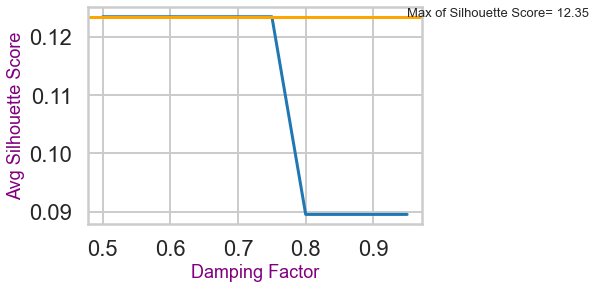

In [26]:
#Hyperparameter tuning
#Make a list of dampings with 10 random number from [0.5,10)
dampings = np.linspace(0.5,1,10, endpoint= False)

avg_silhouette_scores= []
best_score= 0

#Calculate Silhouette avg score to know about density and sepatation of clusters
for d in dampings:
    affinity_model = AffinityPropagation(damping=d)
    af_clusters = affinity_model.fit_predict(X)
    silhouette_avg = silhouette_score(X, af_clusters, random_state= 21)  # need random_state?
    avg_silhouette_scores.append(silhouette_avg)
    
    #update best silhouette score
    if silhouette_avg > best_score:
        best_score = silhouette_avg  
        best_damping = d
    

plt.plot(dampings, avg_silhouette_scores)
plt.xlabel('Damping Factor', fontsize=18, c='purple')
plt.ylabel('Avg Silhouette Score', fontsize=18, c='purple')
max_silh_score = round(np.max(avg_silhouette_scores),4)
plt.axhline(y= max_silh_score, c= 'orange')
plt.annotate('Max of Silhouette Score= {}'.format(max_silh_score *100), (d,max_silh_score), fontsize=13)
print('Best damping factor is 0.5')
plt.show()

In [27]:
affinity_model = AffinityPropagation(damping= 0.5)
ap_clusters = affinity_model.fit_predict(X)
centroids = affinity_model.cluster_centers_indices_
n_clusters = len(centroids)
cluster_ID = affinity_model.labels_

sil_score_af = round(silhouette_score(X, cluster_ID)*100,2)

print('Estimated number of clusters: {}'.format(n_clusters))
print('Avg Silhouette Score: {}'.format(sil_score_af ))

sil_models.append(sil_score_af)
n_clusters_models.append(n_clusters)


Estimated number of clusters: 14
Avg Silhouette Score: 12.35


C:\Users\bahra\Anaconda\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


### Spectral Clustering

In multivariate statistics and the clustering of data, spectral clustering techniques make use of the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. The similarity matrix is provided as an input and consists of a quantitative assessment of the relative similarity of each pair of points in the dataset. (https://en.wikipedia.org/wiki/Spectral_clustering)

In [28]:
#Set the number of clusters
spectral = SpectralClustering(n_clusters= 3, random_state= 21)
spectral_clusters = spectral.fit_predict(X)

cluster_ID = spectral.labels_
silh_spectral = round(silhouette_score(X, cluster_ID)*100,2)

print('Avg Silhouette Score: {}'.format(silh_spectral))


sil_models.append(silh_spectral)
n_clusters_models.append(3)

Avg Silhouette Score: 10.61


### Agglomerative clustering

In [29]:
#Tune hyperparameter. Determin the optimal linkage criterion.
linkage = ['ward', 'complete', 'average', 'single']

avg_silhouette_scores= []
best_score= 0           
optimal_linkage = 'single'           
           
          
for l in linkage:           
    #Set number of clusters by 3
    agg = AgglomerativeClustering(n_clusters=3, linkage= l)
    agg_clusters = agg.fit_predict(X)
    silh_agg = round(silhouette_score(X,agg_clusters)*100,2)
    
    
    if silh_agg > best_score:
        best_score= silh_agg
        optimal_linkage = l

print('Avg Silhouette Score: {}'.format(best_score))     
print('Optimal linkage: {}'.format(optimal_linkage))


Avg Silhouette Score: 18.99
Optimal linkage: average


In [30]:
agg = AgglomerativeClustering(n_clusters=3, linkage= optimal_linkage)
agg_clusters = agg.fit_predict(X)
sil_agg = round(silhouette_score(X, agg_clusters)*100,2)

print('Avg Silhouette Score: {}'.format(sil_agg))

sil_models.append(sil_agg)
n_clusters_models.append(optimal_linkage)

Avg Silhouette Score: 18.99


## DBSCAN

In [31]:
#Hyper tuning. Set min samples by 3 and find the optimal eps
#Define a list of epsilons in range of [0.1,2)
epsilons = np.linspace(0.1,2,10, endpoint=False)

avg_silhouette_scores= []
best_score= 0

for ep in epsilons:
    db = DBSCAN(eps= ep, min_samples =3)
    db_clusters = db.fit_predict(X)
    sil_db = round(silhouette_score(X, db_clusters)*100,2)
    avg_silhouette_scores.append(sil_db)
    
    if sil_db > best_score:
        best_score = sil_db
        optimal_eps = ep
        
print('Avg Silhouette Score: {}'.format(sil_db))        
print('Optimal epsilon: {}'.format(optimal_eps ))            
    
sil_models.append(best_score)
n_clusters_models.append(optimal_eps)    

Avg Silhouette Score: 18.02
Optimal epsilon: 1.81


In [37]:
index= ['KMeans', 'Affinity Propagation', 'Spectral Clustering', 'Agglomerative clustering', 'DBSCAN']

compare_models = pd.DataFrame(sil_models, index=index).reset_index()
compare_models.columns = ['Algorithm', 'Best silhouette score' ]
compare_models 

,Algorithm,Best silhouette score
0,KMeans,11.07
1,Affinity Propagation,12.35
2,Spectral Clustering,10.61
3,Agglomerative clustering,18.99
4,DBSCAN,18.02


**Agglomerative Clustring has the best performance on Data.**